In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import glob as glob

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from zipfile import ZipFile
from urllib.request import urlretrieve

import warnings
import logging
import absl

# filter absl warnings
warnings.filterwarnings('ignore', module='absl')

logging.captureWarnings(True)

absl_logger = logging.getLogger('absl')
absl_logger.setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import sys 
sys.path.append(os.path.abspath('/kaggle/usr/lib/utils/utils.py'))

import utils

In [4]:
URL = r"https://www.dropbox.com/s/wad5js22fbeo1be/camvid_images.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "camvid_images.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    utils.download_and_unzip(URL, asset_zip_path)

In [5]:
image_paths = sorted(glob.glob("camvid_images" + os.sep + "*.png"))

for idx in range(len(image_paths)):
    print(image_paths[idx])

camvid_images/camvid_sample_1.png
camvid_images/camvid_sample_2.png
camvid_images/camvid_sample_3.png
camvid_images/camvid_sample_4.png


In [6]:
def load_image(path):
    image = cv2.imread(path)
    
    # from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image = np.expand_dims(image, axis=0) / 255.0
    
    return image

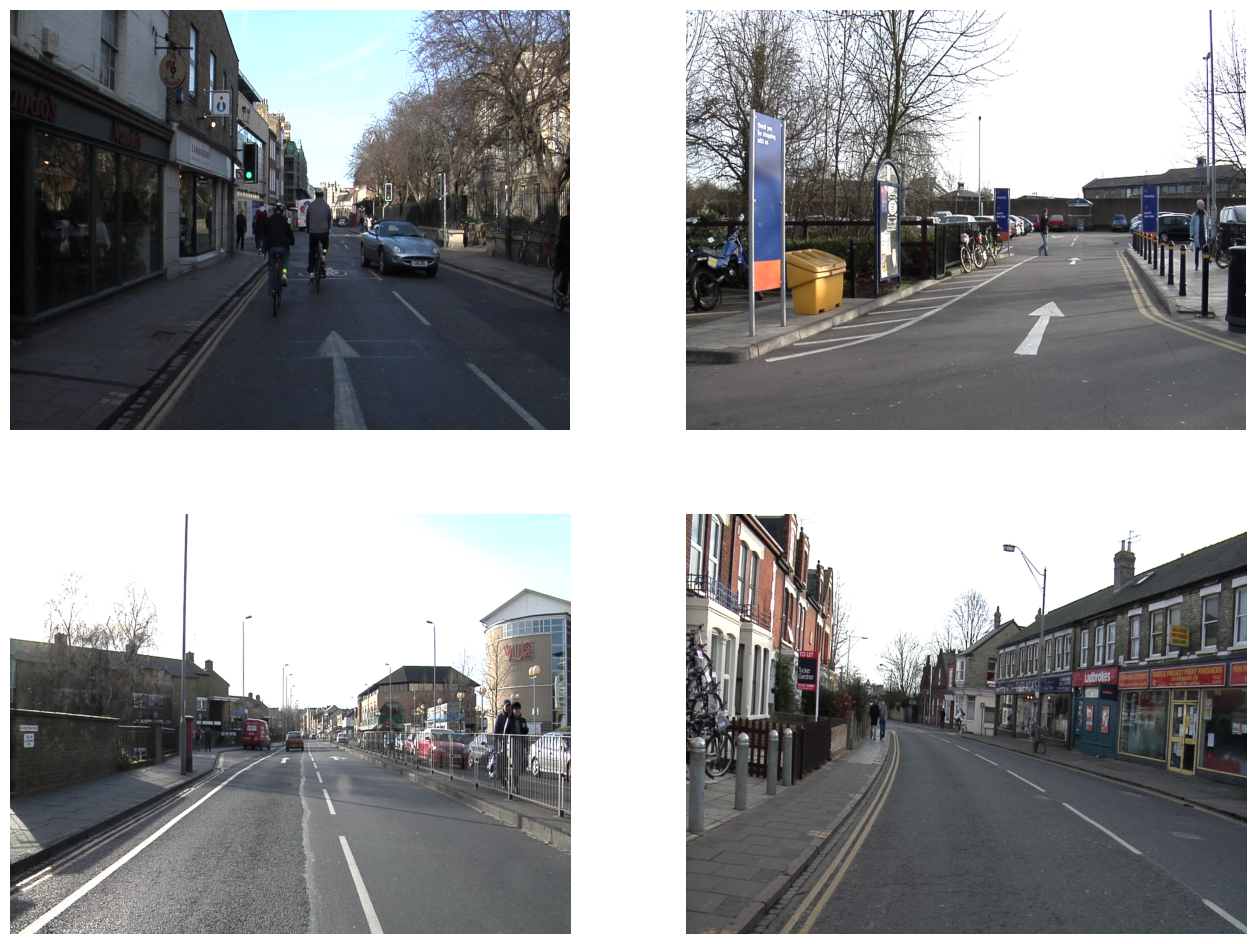

In [7]:
images = []
fix, ax = plt.subplots(nrows=2 ,ncols=2, figsize=(16, 12))

for idx, axis in enumerate(ax.flat):
    image = load_image(image_paths[idx])
    images.append(image)
    axis.imshow(image[0])
    axis.axis('off')

In [8]:
class_index = \
    {
         0: [(64, 128, 64),  'Animal'],
         1: [(192, 0, 128),  'Archway'],
         2: [(0, 128, 192),  'Bicyclist'],
         3: [(0, 128, 64),   'Bridge'],
         4: [(128, 0, 0),    'Building'],
         5: [(64, 0, 128),   'Car'],
         6: [(64, 0, 192),   'Cart/Luggage/Pram'],
         7: [(192, 128, 64), 'Child'],
         8: [(192, 192, 128),'Column Pole'],
         9: [(64, 64, 128),  'Fence'],
        10: [(128, 0, 192),  'LaneMkgs Driv'],
        11: [(192, 0, 64),   'LaneMkgs NonDriv'],
        12: [(128, 128, 64), 'Misc Text'],
        13: [(192, 0, 192),  'Motorcycle/Scooter'],
        14: [(128, 64, 64),  'Other Moving'],
        15: [(64, 192, 128), 'Parking Block'],
        16: [(64, 64, 0),    'Pedestrian'],
        17: [(128, 64, 128), 'Road'],
        18: [(128, 128, 192),'Road Shoulder'],
        19: [(0, 0, 192),    'Sidewalk'],
        20: [(192, 128, 128),'Sign Symbol'],
        21: [(128, 128, 128),'Sky'],
        22: [(64, 128, 192), 'SUV/Pickup/Truck'],
        23: [(0, 0, 64),     'Traffic Cone'],
        24: [(0, 64, 64),    'Traffic Light'],
        25: [(192, 64, 128), 'Train'],
        26: [(128, 128, 0),  'Tree'],
        27: [(192, 128, 192),'Truck/Bus'],
        28: [(64, 0, 64),    'Tunnel'],
        29: [(192, 192, 0),  'Vegetation Misc'],
        30: [(0, 0, 0),      'Void'],
        31: [(64, 192, 0),   'Wall']  
    }

In [9]:
model_url = "https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1"
print("loading model:", model_url)

seg_model = hub.load(model_url)
print("\nModel loaded!")

loading model: https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1

Model loaded!


In [10]:
pred_mask = seg_model.predict(images[0])

print(f'Shape of predicted mask: {pred_mask.shape}')

Shape of predicted mask: (1, 720, 960, 33)


In [11]:
pred_mask = pred_mask.numpy()

pred_mask = pred_mask[:, :, :, 1:]

pred_mask = np.squeeze(pred_mask)

print(f'Shape of predicted mask after removal of batch dimension and background class: {pred_mask.shape}')

Shape of predicted mask after removal of batch dimension and background class: (720, 960, 32)


(-0.5, 959.5, 719.5, -0.5)

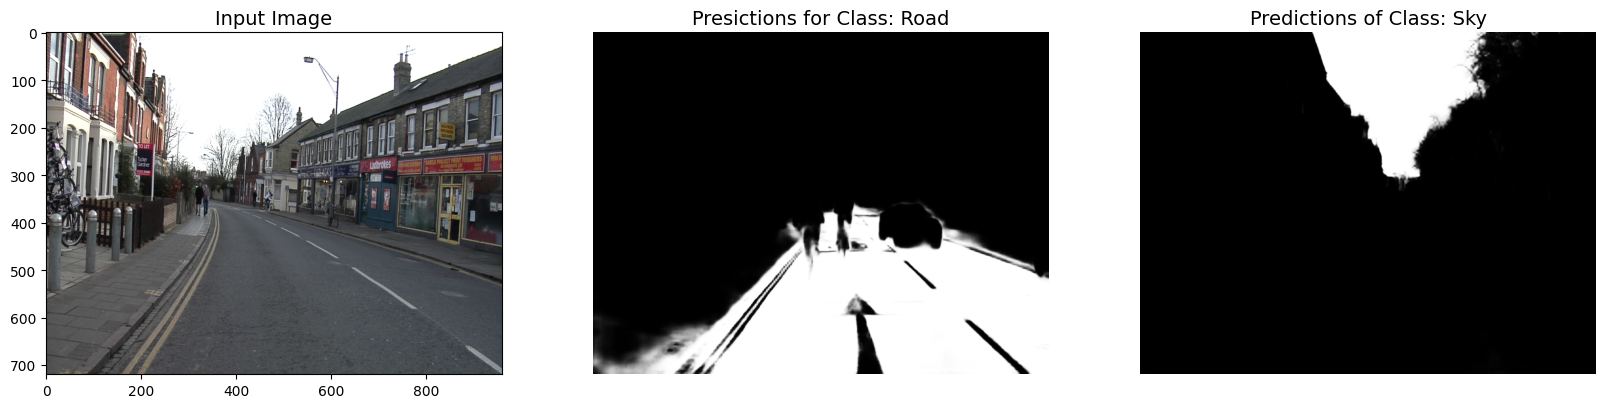

In [12]:
# Each channel in `pred_mask` contains the probabilities that the pixels
# in the original image are associated with the class for that channel.
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title('Input Image', fontsize=14)
plt.imshow(np.squeeze(image[0]))


plt.subplot(1, 3, 2)
plt.title('Presictions for Class: Road', fontsize=14)
plt.imshow(pred_mask[:, :, 17], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predictions of Class: Sky', fontsize=14)
plt.imshow(pred_mask[:, :, 21], cmap='gray')
plt.axis('off')

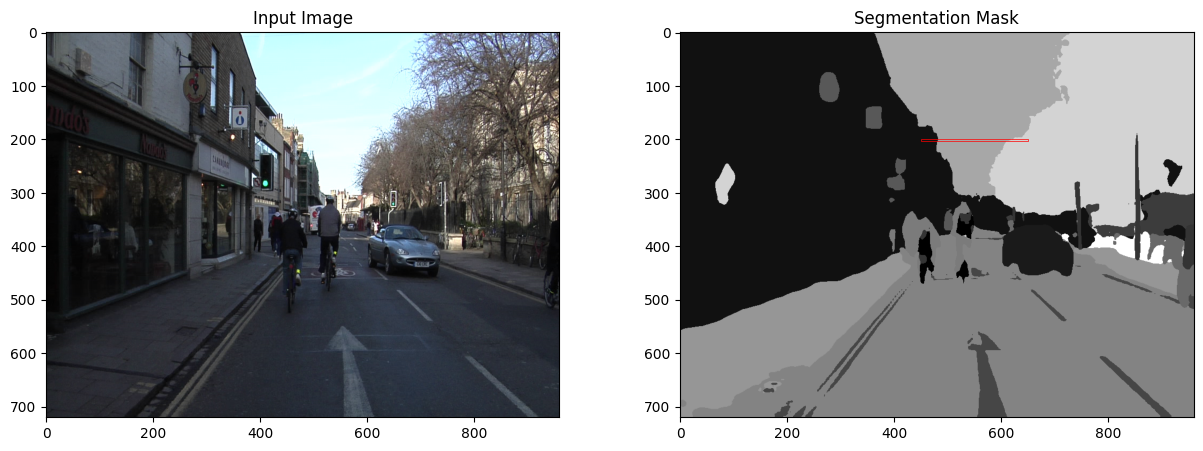

In [13]:
# Assign each pixel in the image a class ID based on the channel that contains the
# highest probability score. This can be implemented using the `argmax` function.
pred_mask_class = np.argmax(pred_mask, axis=-1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Input Image', fontsize=12)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1, 2, 2)
plt.title('Segmentation Mask', fontsize=12)
plt.imshow(pred_mask_class, cmap='gray')
plt.gca().add_patch(Rectangle((450, 200), 200, 3, edgecolor='red', facecolor='none', lw=0.5))

In [14]:
def create_zeros_map(mask_class):
    return np.zeros_like(mask_class).astype(np.uint8)

# single channel mask representation to RGB mask
def class_to_rgb(mask_class, class_index):
    r_map = create_zeros_map(mask_class)
    g_map = create_zeros_map(mask_class)
    b_map = create_zeros_map(mask_class)
    
    for class_id in range(len(class_index)):
        index = mask_class == class_id
        r_map[index] = class_index[class_id][0][0]
        g_map[index] = class_index[class_id][0][1]
        b_map[index] = class_index[class_id][0][2]
        
    seg_map_rgb = np.stack([r_map, g_map, b_map], axis=2)
        
    return seg_map_rgb

(-0.5, 959.5, 719.5, -0.5)

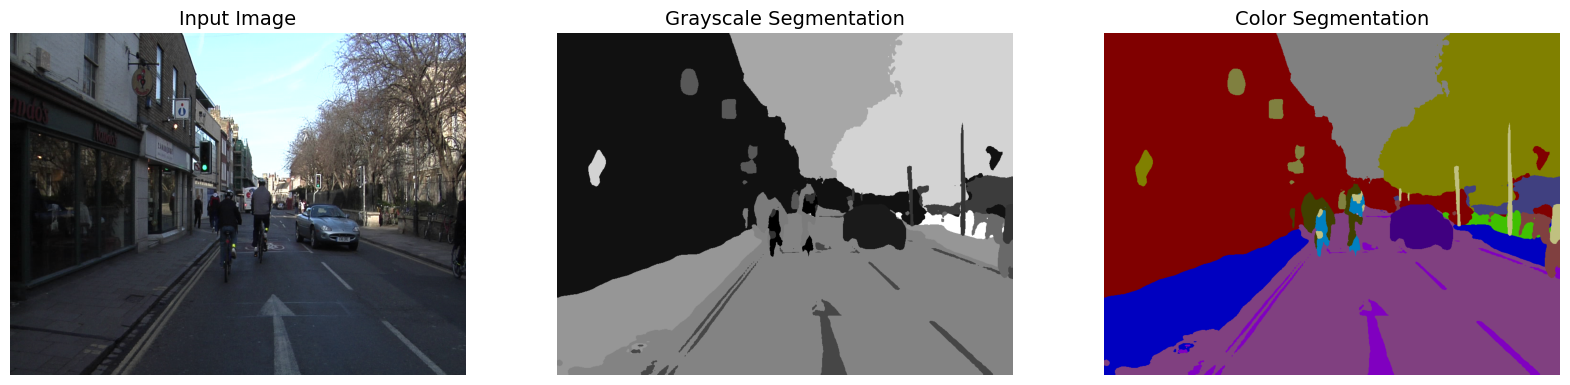

In [15]:
pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)

plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.title('Input Image', fontsize=14)
plt.imshow(np.squeeze(images[0]))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Grayscale Segmentation', fontsize=14)
plt.imshow(pred_mask_class, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Color Segmentation', fontsize=14)
plt.imshow(pred_mask_rgb, cmap='gray')
plt.axis('off')

In [16]:
def image_overlay(image, seg_map_rgb):
    alpha = 0.0
    beta = 0.6
    gamma = 0.0
    
    image = (image * 255.0).astype(np.uint8)
    seg_map_rgb = cv2.cvtColor(seg_map_rgb, cv2.COLOR_RGB2BGR)
    
    image = cv2.addWeighted(image, alpha, seg_map_rgb, beta, gamma)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

In [17]:
# to be continued